In [11]:
from sklearn.svm import SVC # I will be using Support Vector Machines as one method to evaluate the dataset and make predictions.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import numpy as np
from seaborn import load_dataset, pairplot
from sklearn.ensemble import RandomForestRegressor # My second method of evaluation is random forest trees.
from sklearn.tree import export_graphviz
import pydot
import warnings
warnings.filterwarnings('ignore')

In [12]:
VC_Gaussian = SVC(kernel='rbf')
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
#print(stroke_data.to_string())

print(stroke_data.shape) # The dataset has 5,110 rows and 12 columns. 250 people had strokes, 4,860 people did not. Now we will remove some outliers and then null values.

print(stroke_data.describe()) # It appears there is more than one person with a BMI greater than 70 which are extreme outliers. We will remove them.

(5110, 12)
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.1

In [13]:
bmi_error = stroke_data[stroke_data['bmi'] > 70].index
stroke_data.drop(bmi_error, inplace = True)

# There are also a sizeable portion of non-stroke patients who are under the age of 1 year old. The youngest stroke patient was 1.24 years old. Let's remove all people below 1 years old.
younger_than_one = stroke_data[stroke_data['age'] < 1].index
stroke_data.drop(younger_than_one, inplace = True)

# There is only one person whose gender is marked as "Other". They will be removed from the dataset.
remove_other = stroke_data[stroke_data['gender'] == "Other"].index
stroke_data.drop(remove_other, inplace = True)

stroke_data = stroke_data.dropna(how = 'any', axis = 0)
print(stroke_data.shape) # After removing all rows with null values the dataset has 4,908 rows. 209 people had strokes, 4,655 people did not.

gender_dictionary = {'Male' : 0, 'Female': 1}
stroke_data['gender'] = stroke_data['gender'].apply(lambda x: gender_dictionary[x]) # For ease of access, we will change all "Male" entries in the gender column to 0 and female to 1.

married_dictionary = {'No' : 0, 'Yes' : 1}
stroke_data['ever_married'] = stroke_data['ever_married'].apply(lambda x: married_dictionary[x]) # Same thing here for ever_married. 0 for no, 1 for yes.

residence_dictionary = {'Urban' : 0, 'Rural' : 1}
stroke_data['Residence_type'] = stroke_data['Residence_type'].apply(lambda x: residence_dictionary[x]) # Same here for Residence_type. 0 for Urban, 1 for Rural.

smoking_dictionary = {'never smoked' : 0, 'smokes' : 1, 'formerly smoked' : 2, 'Unknown' : 3}
stroke_data['smoking_status'] = stroke_data['smoking_status'].apply(lambda x: smoking_dictionary[x]) # A non-insignificant portion of the smoking habits are "Unknown", but most are known. So we will include them.

stroke_data = stroke_data.drop("work_type", axis = 1) # The vast majority of employment types are "Private". We are going to remove this column from the dataset. Perhaps we can retry it later if our model has low accuracy.
stroke_data = stroke_data.drop("id", axis = 1) # The id column is not neccessary.

(4862, 12)


            gender          age  hypertension  heart_disease  ever_married  \
count  4862.000000  4862.000000   4862.000000    4862.000000   4862.000000   
mean      0.592555    43.245241      0.092143       0.049979      0.658577   
std       0.491410    22.309873      0.289258       0.217925      0.474236   
min       0.000000     1.000000      0.000000       0.000000      0.000000   
25%       0.000000    25.000000      0.000000       0.000000      0.000000   
50%       1.000000    45.000000      0.000000       0.000000      1.000000   
75%       1.000000    61.000000      0.000000       0.000000      1.000000   
max       1.000000    82.000000      1.000000       1.000000      1.000000   

       Residence_type  avg_glucose_level          bmi  smoking_status  \
count     4862.000000        4862.000000  4862.000000     4862.000000   
mean         0.492596         105.385666    28.941094        1.383793   
std          0.499997          44.515431     7.648555        1.261022   
min  

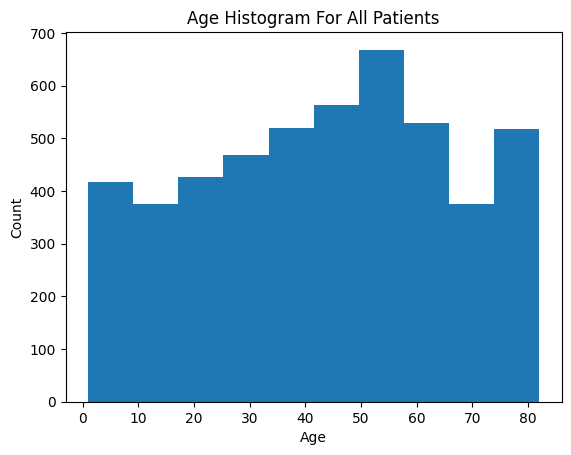

{0: [249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 347, 348, 349, ...], 1: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 49, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 80, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, ...]}
0      67.0
2      80.0
3      49.0
4      79.0
5      81.0
       ...

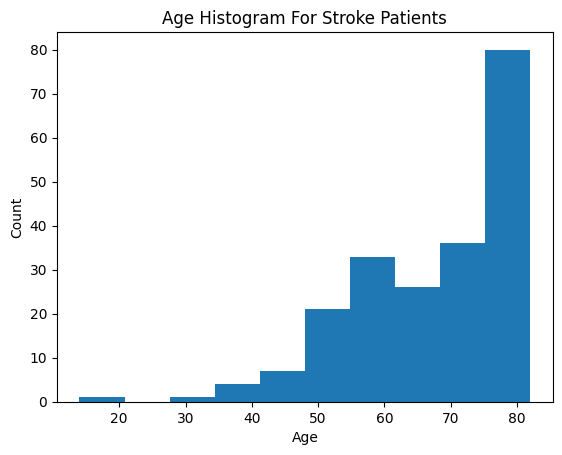

count    209.000000
mean      67.712919
std       12.402848
min       14.000000
25%       58.000000
50%       70.000000
75%       78.000000
max       82.000000
Name: age, dtype: float64


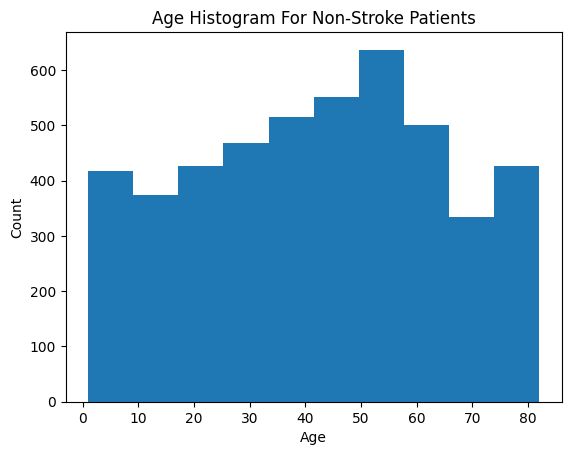

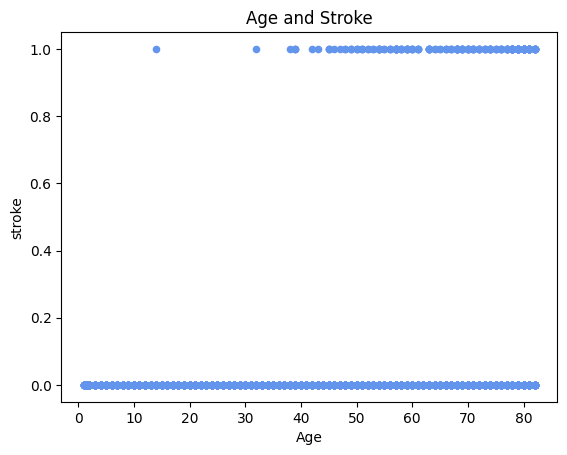

In [14]:
# Now let's do a bit of EDA. I would like to see a histogram of the ages overall, of patients who had strokes, and of patients who did not.
print(stroke_data.describe())

plt.hist(stroke_data["age"])
plt.title("Age Histogram For All Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# The ages overall seem to be fairly normally distributed.

group_by_stroke = stroke_data.groupby(stroke_data['stroke'])
print(group_by_stroke.groups)
print(group_by_stroke.get_group(1)['age'])

plt.hist(group_by_stroke.get_group(1)['age'])
plt.title("Age Histogram For Stroke Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
# The histogram has extreme left skew. It is possible that age is one of the biggest factors in determining the likelihood of a stroke.
print(group_by_stroke.get_group(1)['age'].describe())
# The average age of a stroke patient was 67.7 years old and the 50th percentile of age was 70 years old.

plt.hist(group_by_stroke.get_group(0)['age'])
plt.title("Age Histogram For Non-Stroke Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()
# The histogram is approximately normally distributed. Let's visualize the age and stroke relationship in a scatterplot.

stroke_data.plot(x = 'age', y = 'stroke', kind = 'scatter', c = 'cornflowerblue', title = 'Age and Stroke', xlabel = 'Age', ylabel = 'stroke')
plt.show() # So as we can see and already saw, age seems to be a big factor in determining whether or not somebody has suffered a stroke or not. Now we will plot BMI.

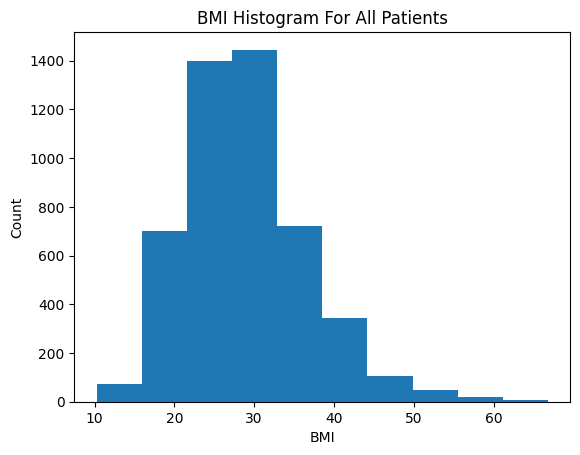

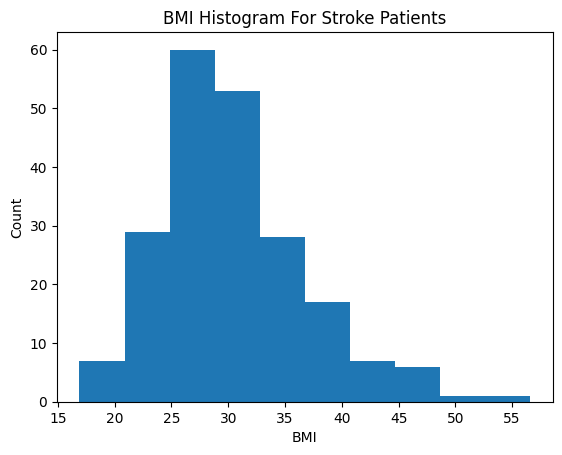

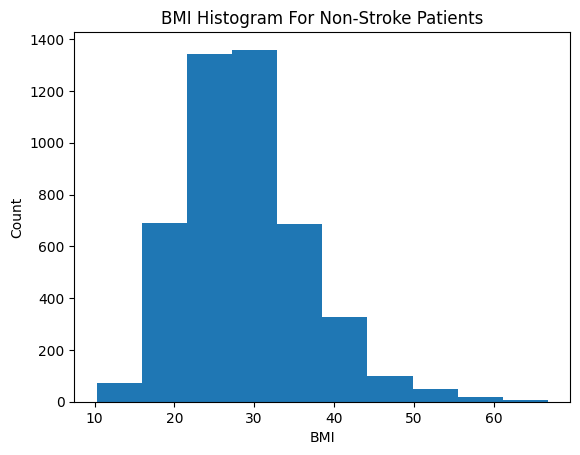

In [15]:
plt.hist(stroke_data["bmi"])
plt.title("BMI Histogram For All Patients")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()
# There is some right skew but this should be expected in a BMI graph like this. Now let's compare the BMI graphs of victims and non-victims.

plt.hist(group_by_stroke.get_group(1)['bmi'])
plt.title("BMI Histogram For Stroke Patients")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()
# Some right skew but approx. normally distributed.

plt.hist(group_by_stroke.get_group(0)['bmi'])
plt.title("BMI Histogram For Non-Stroke Patients")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()
# Some right skew but approx. normally distributed. Much smaller differences in BMI than in Age for victims and non-victims.
# One problem with this dataset is that the number of non-victims outnumbers victims by almost 20 to 1. So we will take 120 non-victims and 120 victims and then create the testing and training sets.
# I am not using all 209 victims as I feel this would overtrain on the data available to us. So we will use about 60% of what we have.

In [16]:
first_avg_accuracy = 0
first_avg_precision = 0
first_avg_recall = 0
first_loop = 0

while (first_loop < 25):
  victims = stroke_data[stroke_data.stroke == 1].sample(125)
  non_victims = stroke_data[stroke_data.stroke == 0].sample(125)
  combined_data = pd.concat([victims, non_victims])
      #print(combined_data)
  inputs = combined_data.loc[:, ~combined_data.columns.isin(['id', 'stroke'])]
  target = combined_data['stroke']
      #print(inputs)
      #print(target)

  X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.4, random_state = random.randint(0,150)) # Seperate 60% into training and 40% into the test data.


  VC_Gaussian.fit(X_train, y_train)
  y_pred = VC_Gaussian.predict(X_test)
  first_avg_accuracy = first_avg_accuracy + metrics.accuracy_score(y_test, y_pred)
  first_avg_precision = first_avg_precision + metrics.precision_score(y_test, y_pred)
  first_avg_recall = first_avg_recall + metrics.recall_score(y_test, y_pred)
  first_loop = first_loop + 1

first_avg_accuracy = first_avg_accuracy / 25
first_avg_precision = first_avg_precision / 25
first_avg_recall = first_avg_recall / 25

print("Average accuracy over 25 runs of the first model: " + str(first_avg_accuracy))
print("Average precision over 25 runs of the first model: " + str(first_avg_precision))
print("Average recall over 25 runs of the first model: " + str(first_avg_recall))
# I would now like to see which of the predictors in our model is most significant. We will use F-scores to see.

selector = SelectKBest(f_classif, k = 5)
selected_features = selector.fit_transform(X_train, y_train)
f_score_indexes = (-selector.scores_).argsort()[:5]
    #print(selected_features)
    #print(f_score_indexes)

# It seems like age (1) is the most important factor in determining whether or not somebody has had a stroke. Depending on the sampling, heart_disease (3), marriage (4), hypertension (2), and glucose level (6).
# Let's try a model with just these predictors and see if we can improve our accuracy. First we will resample.

Average accuracy over 25 runs of the first model: 0.7512000000000001
Average precision over 25 runs of the first model: 0.7165131923280792
Average recall over 25 runs of the first model: 0.8430166243671322


In [17]:
second_avg_accuracy = 0
second_avg_precision = 0
second_avg_recall = 0
second_loop = 0

while (second_loop < 25):

  victims = stroke_data[stroke_data.stroke == 1].sample(125)
  non_victims = stroke_data[stroke_data.stroke == 0].sample(125)
  combined_data = pd.concat([victims, non_victims])

  combined_data = combined_data.drop("bmi", axis = 1)
  combined_data = combined_data.drop("smoking_status", axis = 1)
  combined_data = combined_data.drop("Residence_type", axis = 1)
  combined_data = combined_data.drop("gender", axis = 1)

  inputs = combined_data.loc[:, ~combined_data.columns.isin(['id', 'stroke'])]
  target = combined_data['stroke']
      #print(inputs)
      #print(target)

  X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.4, random_state = random.randint(0,150)) # Seperate 60% into training and 40% into the test data.

  VC_Gaussian.fit(X_train, y_train)
  y_pred = VC_Gaussian.predict(X_test)

  second_avg_accuracy = second_avg_accuracy + metrics.accuracy_score(y_test, y_pred)
  second_avg_precision = second_avg_precision + metrics.precision_score(y_test, y_pred)
  second_avg_recall = second_avg_recall + metrics.recall_score(y_test, y_pred)
  second_loop = second_loop + 1

second_avg_accuracy = second_avg_accuracy / 25
second_avg_precision = second_avg_precision / 25
second_avg_recall = second_avg_recall / 25

print("Average accuracy over 25 runs of the second model: " + str(second_avg_accuracy))
print("Average precision over 25 runs of the second model: " + str(second_avg_precision))
print("Average recall over 25 runs of the second model: " + str(second_avg_recall))

# The two models seem to have pretty much the same accuracy, perhaps the second usually being slighly more accurate. Let's see if a random forest model can give us a better accuracy rate.

Average accuracy over 25 runs of the second model: 0.754
Average precision over 25 runs of the second model: 0.7235129379831728
Average recall over 25 runs of the second model: 0.8261658750068709


In [18]:
stroke_dictionary = {0 : 1, 1 : 2}
stroke_data['stroke'] = stroke_data['stroke'].apply(lambda x: stroke_dictionary[x]) # I am doing this so we can avoid a divide by zero error when calculating accuracy. 1 is a non-victim, 2 is a victim.

targets = np.array(stroke_data['stroke'])
inputs = stroke_data.drop('stroke', axis = 1)
column_names = list(inputs.columns)
inputs = np.array(inputs)

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.4, random_state = 70)

    #baseline_preds = X_test[:, column_names.index('stroke')]
    #baseline_errors = abs(baseline_preds - y_test)
    #print('Average baseline error: ', round(np.mean(baseline_errors), 2))
    #train_features, test_features, train_labels, test_labels = 
rf = RandomForestRegressor(n_estimators = 1000, random_state = 29)

rf.fit(X_train, y_train)

rf_predictions = rf.predict(X_test)
rf_errors = abs(rf_predictions - y_test)
print('Mean Absolute Error:', round(np.mean(rf_errors), 2), '.')

mape = 100 * (rf_errors / y_test)
print(mape)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') # We have an accuracy of 93.71% with this model. Let's visualize one of the trees.

example_tree = rf.estimators_[5]

export_graphviz(example_tree, out_file = 'example_tree.dot', feature_names = column_names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('example_tree.dot')
graph.write_png('example_tree.png')

# Now let's check what the most important predictors were and if those match the previous models.

Mean Absolute Error: 0.08 .
[ 0.    0.5   0.   ... 39.15  2.1   0.1 ]
Accuracy: 93.71 %.


In [19]:
predictors_for_rf = list(rf.feature_importances_)
predictor_importances = [(feature, round(importance, 2)) for feature, importance in zip(column_names, predictors_for_rf)]
predictor_importances = sorted(predictor_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in predictor_importances]

# According to this model, only 3 predictors have an importance level > 0.1: avg_glucose_level (0.32), bmi (0.27), and age (0.21). Let's fit another model with only these three predictors.

targets = np.array(stroke_data['stroke'])
inputs = stroke_data.drop(['stroke','smoking_status', 'gender', 'hypertension', 'Residence_type', 'heart_disease', 'ever_married'], axis = 1)
#print(inputs)
column_names = list(inputs.columns)
inputs = np.array(inputs)

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.4, random_state = 70)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 29)

rf.fit(X_train, y_train)

rf_predictions = rf.predict(X_test)
rf_errors = abs(rf_predictions - y_test)
print('Mean Absolute Error:', round(np.mean(rf_errors), 2), '.')

mape = 100 * (rf_errors / y_test)
print(mape)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') # We have an accuracy of 93.82% with this model. Marginally better with way less predictors!

example_tree = rf.estimators_[5]

export_graphviz(example_tree, out_file = 'example_tree_less_predictors.dot', feature_names = column_names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('example_tree_less_predictors.dot')
graph.write_png('example_tree_less_predictors.png')

Variable: avg_glucose_level    Importance: 0.32
Variable: bmi                  Importance: 0.27
Variable: age                  Importance: 0.21
Variable: smoking_status       Importance: 0.07
Variable: gender               Importance: 0.03
Variable: hypertension         Importance: 0.03
Variable: Residence_type       Importance: 0.03
Variable: heart_disease        Importance: 0.02
Variable: ever_married         Importance: 0.02
Mean Absolute Error: 0.08 .
[ 0.   0.2  0.  ... 43.6  6.7  0.1]
Accuracy: 93.82 %.
